In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima  # Auto-tuning ARIMA parameters

from modules.utils import feature_engineering_last, filter_data_by_year_month

In [45]:
X = pd.read_csv(
    "/Users/elouan/Repo Github ElouanBahri/Predicting_crypto_prices/Historical Prices for BTCUSDT"
)

In [ ]:
YEARS = [2020, 2021, 2022, 2023, 2024, 2025]

Data = filter_data_by_year_month(X, YEARS)

df = feature_engineering_last(X)

In [46]:
X["log_return"] = np.log(X["close"] / X["close"].shift(1))
X.dropna(inplace=True)

X["timestamp"] = pd.to_datetime(X["timestamp"])  # Ensure datetime format
X.set_index("timestamp", inplace=True)  # Set timestamp as index
X = X.sort_index()

In [ ]:
X = X.resample("15T").ffill()  # Forward fill missing time intervals

In [47]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller Test to know is the series is stationnary or not 
result = adfuller(X["log_return"])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] < 0.05:
    print("✅ Data is stationary (p < 0.05)")
else:
    print("❌ Data is NOT stationary (p > 0.05) - Differencing needed")

ADF Statistic: -49.99793314221417
p-value: 0.0
✅ Data is stationary (p < 0.05)


In [48]:
stepwise_fit = auto_arima(
    X["log_return"], seasonal=False, trace=True, suppress_warnings=True
)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1794477.870, Time=13.75 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1794197.760, Time=7.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1794215.734, Time=6.91 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1794217.113, Time=6.76 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1794477.173, Time=11.54 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1794475.911, Time=16.85 sec


/Users/elouan/anaconda3/envs/Predicting_crypto/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/elouan/anaconda3/envs/Predicting_crypto/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1794187.534, Time=34.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1794495.183, Time=19.85 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-1794461.022, Time=24.68 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-1794494.771, Time=18.44 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-1794503.537, Time=34.47 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-1794478.299, Time=18.97 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-1794017.046, Time=37.85 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=-1794501.154, Time=23.47 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=-1794502.979, Time=24.30 sec
 ARIMA(3,0,5)(0,0,0)[0]             : AIC=-1794475.129, Time=74.24 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-1794501.679, Time=231.82 sec

Best model:  ARIMA(2,0,4)(0,0,0)[0]          
Total fit time: 605.293 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:   

In [49]:
# Use best (p,d,q) from auto_arima()
p, d, q = stepwise_fit.order

# Fit ARIMA model on log returns
model = ARIMA(X["log_return"], order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

/Users/elouan/anaconda3/envs/Predicting_crypto/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/elouan/anaconda3/envs/Predicting_crypto/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/elouan/anaconda3/envs/Predicting_crypto/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/elouan/anaconda3/envs/Predicting_crypto/li

                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:               213655
Model:                 ARIMA(2, 0, 4)   Log Likelihood              897260.906
Date:                Thu, 06 Feb 2025   AIC                       -1794505.811
Time:                        22:43:19   BIC                       -1794423.634
Sample:                             0   HQIC                      -1794481.694
                             - 213655                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.535e-05   7.48e-06      2.052      0.040    6.86e-07       3e-05
ar.L1          1.0556      0.039     26.814      0.000       0.978       1.133
ar.L2         -0.3448      0.037     -9.332      0.0

In [59]:
forecast_steps = 10000  # 40 x 15-minute = 10 hours

# Forecast log returns
forecast_log_return = model_fit.forecast(steps=forecast_steps)
print(forecast_log_return.head())  # Check first few values

/Users/elouan/anaconda3/envs/Predicting_crypto/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/elouan/anaconda3/envs/Predicting_crypto/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


213655    0.000054
213656    0.000031
213657    0.000015
213658    0.000023
213659    0.000023
Name: predicted_mean, dtype: float64


In [60]:
# Get last known price
last_price = X["close"].iloc[-1]

# Convert log returns to absolute prices
forecast_prices = last_price * np.exp(np.cumsum(forecast_log_return))

# Generate 15-minute timestamps for forecast
forecast_dates = pd.date_range(start=X.index[-1], periods=forecast_steps, freq="15T")

# Create DataFrame for results
forecast_df = pd.DataFrame(
    {"Date": forecast_dates, "Forecasted Price": forecast_prices}
)
forecast_df.set_index("Date", inplace=True)

print(forecast_df.head(10000))  # Check first forecasted prices

                               Forecasted Price
Date                                           
1970-01-01 00:00:00.000213655      98101.170966
1970-01-01 00:15:00.000213655      98104.253010
1970-01-01 00:30:00.000213655      98105.738738
1970-01-01 00:45:00.000213655      98107.958621
1970-01-01 01:00:00.000213655      98110.225110
...                                         ...
1970-04-15 02:45:00.000213655     114368.209245
1970-04-15 03:00:00.000213655     114369.964345
1970-04-15 03:15:00.000213655     114371.719472
1970-04-15 03:30:00.000213655     114373.474625
1970-04-15 03:45:00.000213655     114375.229806

[10000 rows x 1 columns]


/var/folders/41/lv7xy5r91x7ckkgx5zqmgpxh0000gn/T/ipykernel_19063/734118473.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast_dates = pd.date_range(start=X.index[-1], periods=forecast_steps, freq='15T')


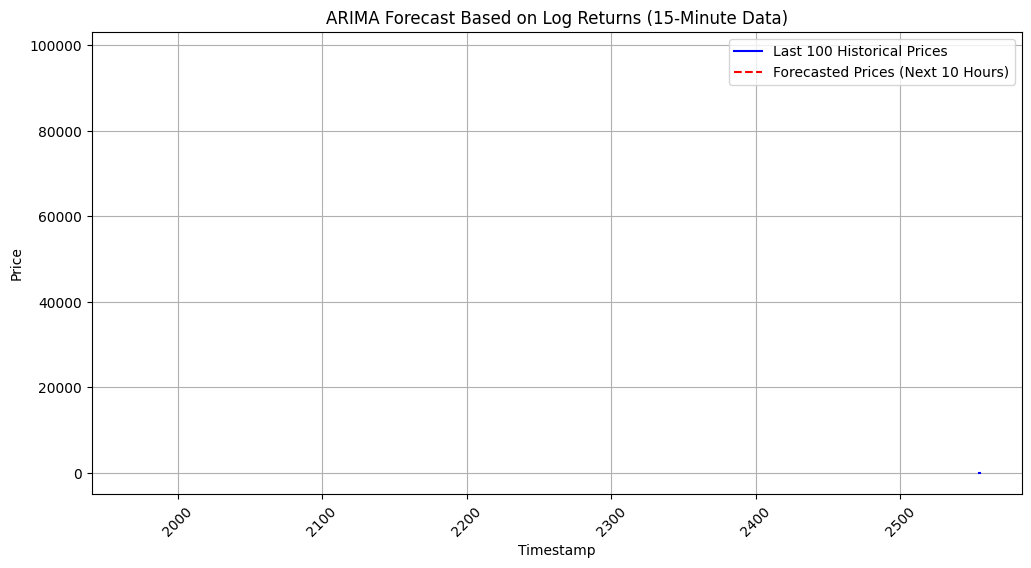

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot last 100 historical prices
plt.plot(
    df.index[-100:],
    df["close"].iloc[-100:],
    label="Last 100 Historical Prices",
    color="blue",
)

# Plot forecasted prices
plt.plot(
    forecast_df.index,
    forecast_df["Forecasted Price"],
    label="Forecasted Prices (Next 10 Hours)",
    linestyle="dashed",
    color="red",
)

# Fix x-axis formatting
plt.xticks(rotation=45)  # Rotate timestamps for better readability
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("ARIMA Forecast Based on Log Returns (15-Minute Data)")
plt.legend()
plt.grid()

plt.show()

_________________
GARCH

In [ ]:
X["log_return"] = np.log(X["close"] / X["close"].shift(1))
X.dropna(inplace=True)

In [ ]:
from arch import arch_model

# Fit GARCH on log returns
garch = arch_model(X["log_return"].dropna(), vol="Garch", p=1, q=1)
garch_fit = garch.fit(disp="off")

# Forecast volatility (next 30 steps)
forecast_vol = garch_fit.forecast(start=len(df), horizon=30)